### Install richdem
- Should only need to be done once per session
- May need to restart kernel

In [3]:
pip install richdem

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Import modules

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datacube.utils import cog
import glob
import re
import rasterio
from datacube.helpers import write_geotiff
import richdem as rd
import pyproj
from odc.algo import xr_reproject
import sys
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_bandindices import calculate_indices
# from deafrica_temporal_statistics import x

import datacube
dc = datacube.Datacube()

### Define functions

In [5]:
### Function to calculate slope

def xr_terrain(da, attribute=None):
    """
    Using the richdem package, calculates terrain attributes
    on a DEM stored in memory as an xarray.DataArray 
    
    Params
    -------
    da : xr.DataArray
    attribute : str
        One of the terrain attributes that richdem.TerrainAttribute()
        has implemented. e.g. 'slope_riserun', 'slope_percentage', 'aspect'.
        See all option here:  
        https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute
        
    """
    #remove time if its there
    da = da.squeeze()
    #convert to richdem array
    rda = rd.rdarray(da.data, no_data=da.attrs['nodata'])
    #add projection and geotransform
    rda.projection=pyproj.crs.CRS(da.attrs['crs']).to_wkt()
    rda.geotransform = da.geobox.affine.to_gdal()
    #calulate attribute
    attrs = rd.TerrainAttribute(rda, attrib=attribute)

    #return as xarray DataArray
    return xr.DataArray(attrs,
                        attrs=da.attrs,
                        coords={'x':da.x, 'y':da.y},
                        dims=['y', 'x'])

In [13]:
### Function to get coordinates from tile

def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}

In [6]:
### Function to get koppen tile with same coordinates as other dataset

def get_koppen_tile(da):
    koppen = rasterio.open(
        "/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif"
    )  # 1km resolution
    dest = np.zeros(da.shape)
    src_transform = koppen.transform
    koppen_tile = rasterio.warp.reproject(
        koppen.read(),
        dest,
        src_crs=koppen.crs,
        dst_crs="EPSG:3577",
        src_transform=src_transform,
        dst_transform=da.transform,
    )
    return koppen_tile[0].astype(int)

### Create wet vegetation masks

In [7]:
### Choose tiles to loop through

extra_tiles = [
    '-10_-36','11_-40','12_-48','-13_-27','14_-41','15_-22','-15_-36','16_-34','16_-39',
    '20_-32','3_-35','5_-30','5_-38','6_-39','6_-40','8_-20','8_-28','9_-36',
    '12_-47','14_-35','3_-14','0_-13','8_-31','17_-39','14_-23'
]

test_tiles = ['8_-31','17_-39','14_-23']

problem_tiles = ['11_-40']

11_-40
steep.slope <xarray.DataArray 'slope' (y: 4000, x: 4000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x        (x) float64 1.1e+06 1.1e+06 1.1e+06 ... 1.2e+06 1.2e+06 1.2e+06
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 ... -4e+06 -4e+06 -4e+06


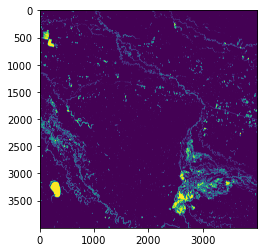

In [17]:
tcw_band = 2 # 90th
tcg_band = 1 # 50th 
tcw_threshold = -350
tcg_threshold = 1000
test = 'test9'

# Folder where the tiles are
tile_folder = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/'
output_folder = f'/g/data/u46/users/gh7133/wet_veg/problem_tiles/{test}/'
    
# for files in tif_files:
for tile in problem_tiles:
    
    print(tile)

    # Load TCW and TCG
    tcw = xr.open_rasterio(f'{tile_folder}LS_TCW_PC_{tile}_1986_2020_summary.tif')
    tcg = xr.open_rasterio(f'{tile_folder}LS_TCG_PC_{tile}_1986_2020_summary.tif')
    
    # Load DEM data
    bounds = get_tile_bounds(tile)
    dem = dc.load(product='srtm_dem1sv1_0', 
                x=(bounds['minx'],bounds['maxx']),
                y=(bounds['miny'],bounds['maxy']),
                crs='EPSG:3577',
                output_crs = 'EPSG:3577',
                resolution=(-25, 25)).squeeze()
    slope = dem.dem #no elevation
    slope = xr_terrain(slope, 'slope_riserun')
    slope = slope.to_dataset(name='slope')
    steep = slope > 0.1
    
    # Apply wetness threshold but not open water
    # might be easier to visualise with water then take it out for final run
    wet = (tcw.isel(band=tcw_band)>tcw_threshold) #& (tcw.isel(band=3)<0)

    # Apply greenness threshold
    green = tcg.isel(band=tcg_band)>tcg_threshold
    
    # Mask wet by greennnes mask
    # wet_masked = wet.where(green_combo_mask != 1)
    green_combo = np.where((green + steep.slope)>=1,1,0)
    wet_masked = wet.where(green != 1,0,0).astype('int32')
    wet_masked.attrs = tcw.attrs
    wet_masked = xr.DataArray(wet_masked, coords=tcw.isel(band=1).coords, dims=tcw.isel(band=1).dims)
    
    # Plot if you only want to look at one
#     plt.imshow(wet_masked)
    
    # Write out
#     cog.write_cog(wet_masked,f'{output_folder}Write_cog_{test}_{tile}.tif')

### Convert tifs into jpg for easy display

In [9]:
# This works
test = 'test5'

import numpy as np
import rasterio
import os
import imageio

for infile in os.listdir(f'/g/data/u46/users/gh7133/wet_veg/problem_tiles/{test}'):
    if infile[-3:] == 'tif':
        print('infile',infile)
        outfile = infile[:-3] + 'jpg'
        print(outfile)
        im = rasterio.open(f'/g/data/u46/users/gh7133/wet_veg/problem_tiles/{test}/'+infile)
        try:
            # Read in RGB
            data = im.read([3,2,1])
            # Swap axes
            data = data.swapaxes(0,1).swapaxes(1,2)
            # Clip values # Normalise array data to 0-255
            rgb = np.clip(data, 0, 2000) / 2000 *255
            # Convert to uint8
            nrgb = rgb.astype('uint8')
            # Flip image
            nrgb = np.rot90(np.rot90(nrgb))
            # Save
            imageio.imwrite(outfile,nrgb)
        except:
            # Read in grayscale
            data = im.read([1])
            # Swap axes
            data = data.swapaxes(0,1).swapaxes(1,2)
            # Clip values # Normalise array data to 0-255
            rgb = np.clip(data, 0, 1)*255
            # Convert to uint8
            nrgb = rgb.astype('uint8')
            # Flip image
            nrgb = nrgb #np.rot90(np.rot90(nrgb))
            # Save
            imageio.imwrite(outfile,nrgb)

infile Write_cog_test5_6_-39.tif
Write_cog_test5_6_-39.jpg
infile Write_cog_test5_-10_-36.tif
Write_cog_test5_-10_-36.jpg
infile Write_cog_test5_-15_-36.tif
Write_cog_test5_-15_-36.jpg
infile Write_cog_test5_20_-32.tif
Write_cog_test5_20_-32.jpg
infile Write_cog_test5_6_-40.tif
Write_cog_test5_6_-40.jpg
infile Write_cog_test5_12_-48.tif
Write_cog_test5_12_-48.jpg
infile Write_cog_test5_5_-38.tif
Write_cog_test5_5_-38.jpg
infile Write_cog_test5_14_-41.tif
Write_cog_test5_14_-41.jpg
infile Write_cog_test5_3_-14.tif
Write_cog_test5_3_-14.jpg
infile Write_cog_test5_14_-23.tif
Write_cog_test5_14_-23.jpg
infile Write_cog_test5_16_-34.tif
Write_cog_test5_16_-34.jpg
infile Write_cog_test5_8_-20.tif
Write_cog_test5_8_-20.jpg
infile Write_cog_test5_12_-47.tif
Write_cog_test5_12_-47.jpg
infile Write_cog_test5_17_-39.tif
Write_cog_test5_17_-39.jpg
infile Write_cog_test5_-13_-27.tif
Write_cog_test5_-13_-27.jpg
infile Write_cog_test5_8_-31.tif
Write_cog_test5_8_-31.jpg
infile Write_cog_test5_8_-28.t

### Many ideas

In [ ]:
# # Folder where the tiles are
# tile_folder = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/'
# output_folder = '/g/data/u46/users/gh7133/wet_veg/test4/'

# # Grab a list of all of the tif files in the tile folder
# tif_files = glob.glob(f"{tile_folder}*.tif")
# tif_files

# # for tile in tile_list:
# #     tcw = glob.glob(f'{new_folder}LS_TCW_PC_{tile}_1986_2020_summary.tif')
# #     print(tcw)
    
# # for files in tif_files:
# for tile in extra_tiles:
    
#     print(tile)
    
#     # Load DEM data
#     bounds = get_tile_bounds(tile)
#     dem = dc.load(product='srtm_dem1sv1_0', 
#                 x=(bounds['minx'],bounds['maxx']),
#                 y=(bounds['miny'],bounds['maxy']),
#                 crs='EPSG:3577',
#                 output_crs = 'EPSG:3577',
#                 resolution=(-25, 25)).squeeze()
#     slope = dem.dem #no elevation
#     slope = xr_terrain(slope, 'slope_riserun')
#     slope = slope.to_dataset(name='slope')
#     steep = slope > 0.1
#     print('steep.slope',steep.slope)
    
#     # Load MrVBF data
#     mrvbf_folder = '/g/data/u46/wofs/confidence_albers/MrVBF/tiles/'
#     mrvbf = xr.open_dataset(f'{mrvbf_folder}mrvbf_{tile}.nc')
#     low = mrvbf.band1.isel(time=0) >= 3 # low and flat areas
#     high = mrvbf.band1.isel(time=0) < 3 # high and steep areas

#     # Load TCW and TCG
#     tcw = xr.open_rasterio(f'{tile_folder}LS_TCW_PC_{tile}_1986_2020_summary.tif')
#     tcg = xr.open_rasterio(f'{tile_folder}LS_TCG_PC_{tile}_1986_2020_summary.tif')

#     # Load koppen data (based on any of the TC tiles)
#     koppen = get_koppen_tile(tcw.isel(band=0))
    
#     # Select koppen values of interest
#     k4 = (koppen == 4) # arid climate
#     k7 = (koppen == 7) # irrigated region
    
#     # Apply wetness threshold but not open water
#     # might be easier to visualise with water then take it out for final run
#     wet = (tcw.isel(band=2)>-350) #& (tcw.isel(band=3)<0)

#     # Apply greenness threshold
#     green_high = tcg.isel(band=1)>1000 # areas steep and high with dark green forest
#     green_low = tcg.isel(band=1)>1000 # EDIT: wetlands in lower areas actually greener than surrounds
#     green = tcg.isel(band=1)>1000

#     # Mask greenness by mrvbf - binary + nan
#     green_high_mrvbf = green_high.where(high == 1)
#     green_low_mrvbf = green_low.where(low == 1)
#     print('green_high_mrvbf',green_high_mrvbf)
#     print('green_low_mrvbf',green_low_mrvbf)

# #     No worries about crops when using higher wet threshold 350
# #     # Create a crop mask for areas with cropping (currently koppen 7)
# #     crop_mask_lt = np.where(tcg.isel(band=1)<600,1,0)
# #     crop_mask_gt = np.where(tcg.isel(band=1)>50,1,0)
# #     crop_mask = np.where((crop_mask_lt + crop_mask_gt)==2,1,0)

#        # If in arid zone don't have a green mask
# #     green_combo_mask = np.where(k4 == 1,0,green_combo)
    
#     # Combine various masks into one
# #     green_combo = np.nansum(np.dstack((green_high_mrvbf, green_low_mrvbf)),2)
#     green_combo = np.where((green + steep.slope)>=1,1,0)
# #     green_combo = np.any([green_high_mrvbf, green_low_mrvbf], axis=0)

#     # Mask wet by greennnes mask
#     # wet_masked = wet.where(green_combo_mask != 1)
#     wet_masked = wet.where(green_combo != 1,0,0).astype('int32')
#     wet_masked.attrs = tcw.attrs
#     wet_masked = xr.DataArray(wet_masked, coords=tcw.isel(band=1).coords, dims=tcw.isel(band=1).dims)
    
# #     plt.figure(figsize=(10,10))
# #     plt.imshow(wet_masked,cmap='Blues',interpolation='gaussian')
# #     plt.colorbar()

# #     print('wet_masked',wet_masked)
# #     print('unique',np.unique(wet_masked.data))
    
# #     write_geotiff(filename=f'Write_geotiff_test3_{tile}', dataset=wet_masked.to_dataset(name='array'))

#     cog.write_cog(wet_masked,f'{output_folder}Write_cog_test4_{tile}.tif')